In [5]:
# Carga de contexto y librerias para el notebook :D
%load_ext kedro.ipython
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [6]:
df = catalog.load("Features_training_v2")   # lee el dataset del catálogo
list(df.columns)  

[10/25/25 03:21:30] INFO     Loading data from Features_training_v2 (ParquetDataset)...        ]8;id=496779;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=46333;file://C:\Users\AlexandreKz\Documents\GitHub\Ml_Bank\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

['Monetary', 'TimeSinceLastTxn', 'IsLateNight', 'AmountZScoreByLocation', 'IsWeekend']

# Este es el primer modelo no lineal

In [7]:
# =========================================================
# 🌳 RANDOM FOREST REGRESSOR – PREDICCIÓN DE MONETARY
# =========================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================================================
# 1️⃣ Variables dependiente e independientes
# =========================================================
X = df[["AmountZScoreByLocation", "TimeSinceLastTxn", "IsLateNight", "IsWeekend"]]
y = df["Monetary"]

# =========================================================
# 2️⃣ División Train/Test
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================================================
# 3️⃣ Modelo Random Forest + Cross Validation
# =========================================================
rf = RandomForestRegressor(
    n_estimators=100,        # cantidad de árboles
    max_depth=None,          # sin límite de profundidad
    random_state=42,
    n_jobs=-1                # usa todos los núcleos
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_r2 = cross_val_score(rf, X_train, y_train, cv=cv, scoring="r2")
cv_rmse = np.sqrt(-cross_val_score(rf, X_train, y_train, cv=cv, scoring="neg_mean_squared_error"))

print("=== Cross Validation Results (5-Fold) ===")
print("R² promedio:", round(cv_r2.mean(), 4))
print("R² desviación:", round(cv_r2.std(), 4))
print("RMSE promedio:", round(cv_rmse.mean(), 2))

# =========================================================
# 4️⃣ Entrenamiento y evaluación
# =========================================================
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

results_rf = {
    "model_name": "RandomForestRegressor",
    "r2_mean_cv": round(cv_r2.mean(), 4),
    "r2_std_cv": round(cv_r2.std(), 4),
    "r2_test": round(r2, 4),
    "rmse": round(rmse, 2),
    "mae": round(mae, 2)
}

print("\n=== Resultados en Test ===")
print(results_rf)

# =========================================================
# 5️⃣ Importancia de variables
# =========================================================
importances = pd.DataFrame({
    "Variable": X.columns,
    "Importancia": rf.feature_importances_.round(4)
}).sort_values("Importancia", ascending=False)

print("\n=== Importancia de las variables ===")
display(importances)

=== Cross Validation Results (5-Fold) ===
R² promedio: 0.6956
R² desviación: 0.0019
RMSE promedio: 507.51

=== Resultados en Test ===
{'model_name': 'RandomForestRegressor', 'r2_mean_cv': np.float64(0.6956), 'r2_std_cv': np.float64(0.0019), 'r2_test': 0.6974, 'rmse': np.float64(505.89), 'mae': 272.58}

=== Importancia de las variables ===


,Variable,Importancia
0,AmountZScoreByLocation,0.8867
1,TimeSinceLastTxn,0.0976
3,IsWeekend,0.0104
2,IsLateNight,0.0053


# El RandomForestRegressor mejora levemente la precisión (menor MAE), pero mantiene un comportamiento igual de estable y sin sobreentrenar.
# Eso es ideal: un modelo más flexible sin perder generalización.

# Variable	Importancia	Interpretación
# AmountZScoreByLocation	0.8867	🔥 Es la variable dominante, explica casi el 89 % de la predicción del gasto.

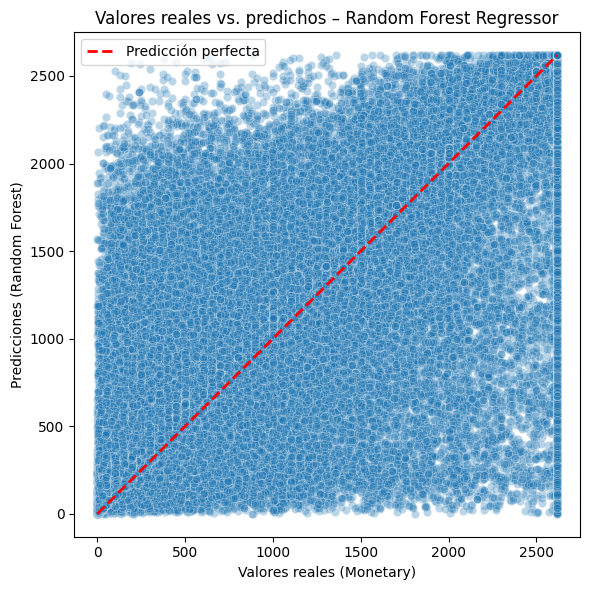

In [8]:
# =========================================================
# 🎯 SCATTERPLOT – Random Forest Regressor
# =========================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', lw=2, label="Predicción perfecta"
)
plt.xlabel("Valores reales (Monetary)")
plt.ylabel("Predicciones (Random Forest)")
plt.title("Valores reales vs. predichos – Random Forest Regressor")
plt.legend()
plt.tight_layout()
plt.show()

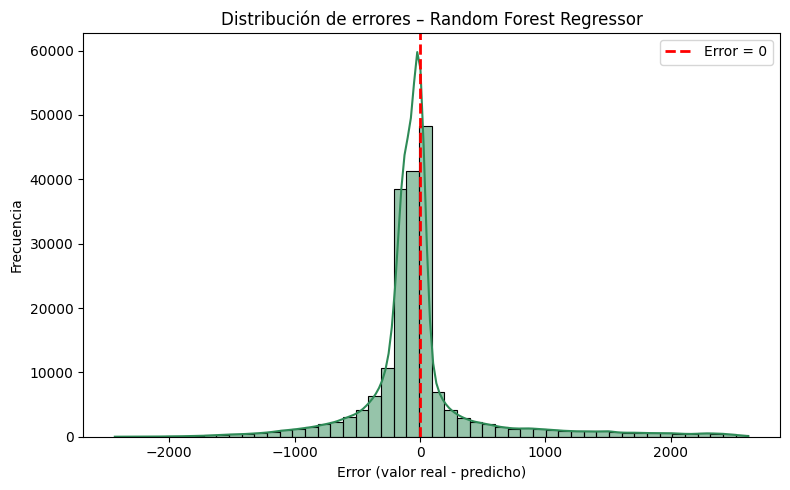

In [9]:
# =========================================================
# 📉 DISTRIBUCIÓN DE ERRORES – Random Forest
# =========================================================
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color="seagreen")
plt.axvline(0, color="red", linestyle="--", lw=2, label="Error = 0")
plt.xlabel("Error (valor real - predicho)")
plt.ylabel("Frecuencia")
plt.title("Distribución de errores – Random Forest Regressor")
plt.legend()
plt.tight_layout()
plt.show()

# El histograma es muy simétrico y concentrado alrededor de 0, con colas pequeñas.

# No hay sesgo fuerte hacia positivos o negativos → el modelo no tiende a sobreestimar ni subestimar de manera sistemática.

# Las colas más largas muestran algunos outliers (clientes con gastos extremos), pero no dominan el resultado.